# Clustering

Clustering techniques are unsupervised learning algos that attempt to group unlabelled data into clusters.

## Data

In [121]:
import torch
from torch import tensor
from torch.distributions.multivariate_normal import MultivariateNormal

n_clusters = 6
n_samples = 250


def sample(m):
    return MultivariateNormal(m, torch.diag(tensor([5.0, 5.0]))).sample((n_samples,))


# We pick 6 random points, centorids, and for each we'll generate 250 random points around it
centroids = torch.rand(n_clusters, 2) * 70 - 35

slices = [sample(c) for c in centroids]
data = torch.cat(slices)

data, data.shape

(tensor([[  0.1856,  17.9307],
         [  1.4213,  19.1341],
         [ -0.2823,  15.0428],
         ...,
         [-18.8583,  21.2841],
         [-18.1149,  22.6393],
         [-21.8276,  24.2664]]),
 torch.Size([1500, 2]))

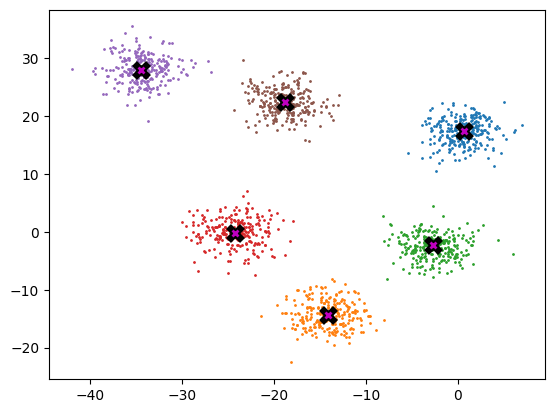

In [122]:
import matplotlib.pyplot as plt


# We can plot the data to check we've done what we thought
def plot_data(centers, points, n_samples, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    for i, centroid in enumerate(centers):
        samples = points[i * n_samples : (i + 1) * n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color="m", mew=2)


plot_data(centroids, data, n_samples)

## Mean shift clustering

Advantages:
    
* Doesn't require selecting the number of clusters in advances (select a bandwidth, can be chosen automatically)
* Can handle clusters of any shape whereas k-means requres roughly ball shaped clusters

Algorithm:

* For each data point x in the sample X, find the distance between x and every other point in X.
* Create weights fo each point in X by using the Gaussian kernel of that points distance to x
  * The weighting approach penalises points further away from x
  * The rate at which the weights fall to 0 is determined by the bandwidth, which is the std dev of the Gaussian
* Update x as the wieghted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

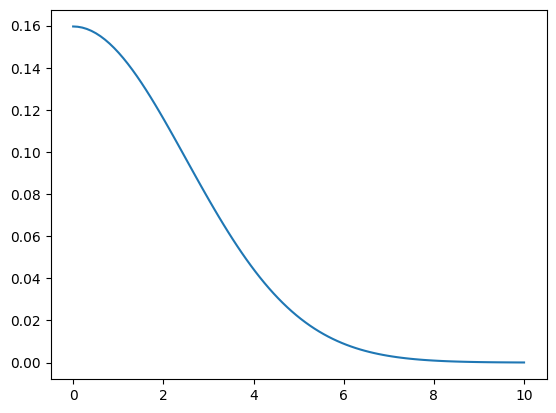

In [123]:
import math
from functools import partial


# Gaussian kernel, also known as the normal distribution
def gaussian(d, bandwidth):
    return torch.exp(-0.5 * ((d / bandwidth)) ** 2) / (bandwidth * math.sqrt(2 * math.pi))


def plot_func(f):
    x = torch.linspace(0, 10, 100)  # 100 numbers 0 to 10
    plt.plot(x, f(x))


# This is how our weights will change with distance
# We need to decide on a bandwidth
# One rule of thumbs is to find a which bandwidth covers one third of the data
plot_func(partial(gaussian, bandwidth=2.5))

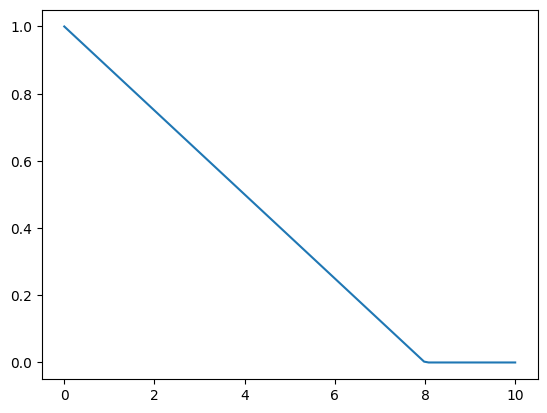

In [124]:
# A simplified way of thinking of this would be a tirangular weighting, we could try this too
def tri(d, i):
    return (-d + i).clamp_min(0) / i


plot_func(partial(tri, i=8))

In [125]:
# We clone the data as we are going to be modifing it each time we iterate
# Lets run through for points D[0]
D = data.clone()

D[0]

tensor([ 0.1856, 17.9307])

In [126]:
D, D.shape, D[0], D[0].shape

(tensor([[  0.1856,  17.9307],
         [  1.4213,  19.1341],
         [ -0.2823,  15.0428],
         ...,
         [-18.8583,  21.2841],
         [-18.1149,  22.6393],
         [-21.8276,  24.2664]]),
 torch.Size([1500, 2]),
 tensor([ 0.1856, 17.9307]),
 torch.Size([2]))

In [127]:
# Remember we can add a unit axis with [None]
D[0], D[0][None], D[0].shape, D[0][None].shape

(tensor([ 0.1856, 17.9307]),
 tensor([[ 0.1856, 17.9307]]),
 torch.Size([2]),
 torch.Size([1, 2]))

In [128]:
# The difference between the first point and the other points
D[0][None] - D

tensor([[ 0.0000,  0.0000],
        [-1.2357, -1.2034],
        [ 0.4679,  2.8880],
        ...,
        [19.0439, -3.3534],
        [18.3004, -4.7085],
        [22.0132, -6.3357]])

In [129]:
# With broadcasting we can just do
D[0] - D

tensor([[ 0.0000,  0.0000],
        [-1.2357, -1.2034],
        [ 0.4679,  2.8880],
        ...,
        [19.0439, -3.3534],
        [18.3004, -4.7085],
        [22.0132, -6.3357]])

In [130]:
# The euclidean distance for D[0] to all other points
dist = ((D[0] - D) ** 2).sum(1).sqrt()
dist

tensor([ 0.0000,  1.7249,  2.9256,  ..., 19.3368, 18.8965, 22.9068])

In [131]:
# This could be written using torch.einsum
dist = torch.einsum("ij,ij->i", D[0] - D, D[0] - D).sqrt()
dist

tensor([ 0.0000,  1.7249,  2.9256,  ..., 19.3368, 18.8965, 22.9068])

In [132]:
# Now we can get the weights
weights = gaussian(dist, 2.5)
weights, weights.shape

(tensor([1.5958e-01, 1.2578e-01, 8.0461e-02,  ..., 1.6288e-14, 6.2642e-14,
         9.3815e-20]),
 torch.Size([1500]))

In [133]:
# Now we want the average of our data weighted by the weights
# For a weighted average we do `sum(val[i] * weights[i]) / sum(weights)`
# So we want to eight like this
(weights[:, None] * D)

tensor([[ 2.9611e-02,  2.8613e+00],
        [ 1.7876e-01,  2.4066e+00],
        [-2.2714e-02,  1.2104e+00],
        ...,
        [-3.0717e-13,  3.4668e-13],
        [-1.1348e-12,  1.4182e-12],
        [-2.0478e-18,  2.2766e-18]])

In [134]:
(weights[:, None] * D).sum(dim=0) / weights.sum()

tensor([ 0.4365, 17.6804])

In [165]:
# Lets put a full iteration in a function
def one_update(D):
    for i, d in enumerate(D):
        dist = ((d - D) ** 2).sum(1).sqrt()
        weights = gaussian(dist, 2.5)
        #         weights = tri(dist, 8)
        D[i] = (weights[:, None] * D).sum(0) / weights.sum()


# And run the iterations bunch of times
def meanshift(in_data):
    D = in_data.clone()
    for i in range(5):
        one_update(D)
    return D

In [166]:
%timeit shifted = meanshift(data)

784 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


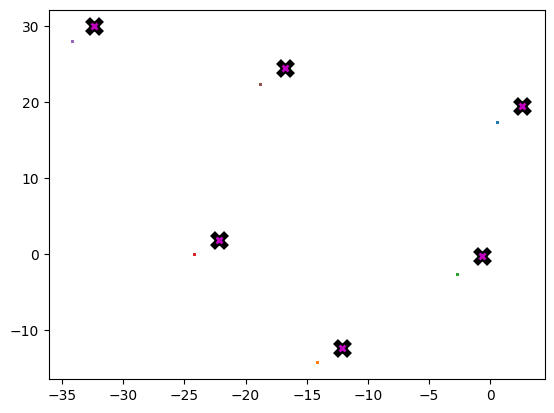

In [181]:
# If we plot the centroids of center we can see all our points have clustered together
plot_data(centroids + 2, shifted, n_samples)

### Animate

This is more fun if we can animate it.

In [197]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def do_one(frame_num):
    #     On first frame plot orig data
    if frame_num == 0:
        plot_data(centroids + 2, D, n_samples, ax=ax)
        return

    one_update(D)
    ax.clear()
    plot_data(centroids + 2, D, n_samples, ax=ax)


D = data.clone()
fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()

HTML(anim.to_jshtml())

### GPU

If we put this on a GPU in its current form it wont help much aw our loop does a point at a time. The good new is that each point is independent so we can batch up a bunch of points and do them all in parallel.

In [201]:
# Lets make a batch to test with
batch_size = 5
B = data.clone()
batch = B[:batch_size]

B.shape, batch.shape,

(torch.Size([1500, 2]), torch.Size([5, 2]))

In [207]:
# We need a distance calc that operates on all of items in tha batch rather than one
# We have a 5x2, batch and distances between 1500x2 full set of points
# That means the output is a matrix that is 5x1500x2

# We have 5x2 and 1500x2 but 5 and 1500 are not compatible for broadcasting so we cant do:
# X - x

# What if we insert an axis into each
# Now we have 5 match 1, 1 match 1500 and 2 match 2, and well broadcast along these
batch[:, None].shape, B[None, :].shape, (batch[:, None] - B[None, :]).shape

(torch.Size([5, 1, 2]), torch.Size([1, 1500, 2]), torch.Size([5, 1500, 2]))

In [218]:
# We can shove it in a new dist function
def dist_b(batch, B):
    return ((batch[:, None] - B[None, :]) ** 2).sum(2).sqrt()  # sum over x/y squareds

In [219]:
dist_b(batch, B)

tensor([[ 0.0000,  1.7249,  2.9256,  ..., 19.3368, 18.8965, 22.9068],
        [ 1.7249,  0.0000,  4.4319,  ..., 20.3932, 19.8481, 23.8087],
        [ 2.9256,  4.4319,  0.0000,  ..., 19.5965, 19.3832, 23.4367],
        [ 1.1361,  1.2453,  3.2701,  ..., 20.4623, 20.0070, 24.0100],
        [ 4.1931,  5.1099,  2.2543,  ..., 21.8310, 21.6337, 25.6873]])

In [223]:
# Our gaussian function still works fine as its operating on the matrix with scalars which happily broadcast
weights = gaussian(dist_b(batch, B), 2.5)
weights

(tensor([[1.5958e-01, 1.2578e-01, 8.0461e-02,  ..., 1.6288e-14, 6.2642e-14,
          9.3815e-20],
         [1.2578e-01, 1.5958e-01, 3.3155e-02,  ..., 5.6715e-16, 3.2797e-15,
          3.2248e-21],
         [8.0461e-02, 3.3155e-02, 1.5958e-01,  ..., 7.2554e-15, 1.4110e-14,
          1.3155e-20],
         [1.4392e-01, 1.4096e-01, 6.7831e-02,  ..., 4.5259e-16, 1.9760e-15,
          1.4927e-21],
         [3.9093e-02, 1.9760e-02, 1.0627e-01,  ..., 4.4102e-18, 8.7590e-18,
          1.8962e-24]]),
 torch.Size([5, 1500]))

In [225]:
# Now we want to weight our batch using the weights we've got, we have a similar broblem with dimensions
weights.shape, B.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [233]:
# We can use the same trick to make broadcasting help us out
weights[..., None].shape, B[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [236]:
(weights[..., None] * B[None]).shape

torch.Size([5, 1500, 2])

In [240]:
# Now we just sum
(weights[..., None] * B[None]).sum(1).shape  # Sum over the 1500 points

torch.Size([5, 2])

In [244]:
# We could do this in einsum instead
# ij = 5x1500
# jk = 1500x2
# ik = 5x2
torch.einsum("ij,jk->ik", weights, B).shape

torch.Size([5, 2])

In [254]:
# Hang on a minute isnt that einsum just a matrix multiplacation
# Yep thats what we have just reinvented
num = weights @ B
num.shape

torch.Size([5, 2])

In [252]:
# The denominator for the wighted average is simpler
div = weights.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [256]:
# So now we have the weighted batch
num / div

tensor([[ 0.4365, 17.6804],
        [ 0.9844, 18.2454],
        [ 0.1469, 16.3096],
        [ 0.9031, 17.7028],
        [ 0.9304, 15.9082]])

In [284]:
# Lets rewrite meanshift to run in batches now
def meanshift(data, batch_size=100):
    L = len(data)
    D = data.clone()

    for _ in range(5):
        for i in range(0, L, batch_size):
            batch = slice(i, min(i + batch_size, L))
            weights = gaussian(dist_b(D[batch], D), 2.5)
            div = weights.sum(1, keepdim=True)
            D[batch] = weights @ D / div
    return D

In [285]:
# Now, we only need a new cuda kernel per batch
%timeit res = meanshift(data.cuda()).cpu()

19.1 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [286]:
# Thats ~100x faster, and bigger batchsize do even better
%timeit res = meanshift(data.cuda(), batch_size=5000).cpu()

2.5 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


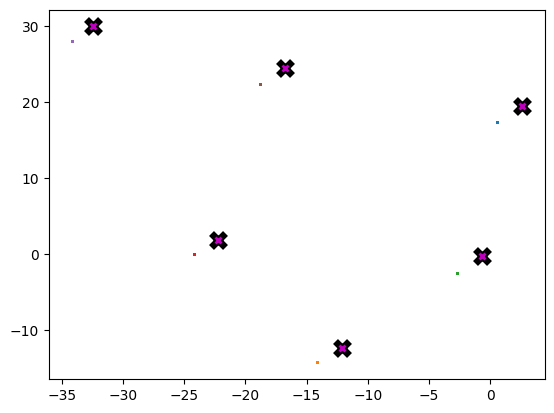

In [273]:
# It still works
plot_data(centroids + 2, res, n_samples)